Before launching the code make sure to have all the releavant requirments and modules  
Be also sure to have set up the Pg database using the .sql file, and change the credetientals to match your own

In [1]:
from utils import scrape_news, clean_html, preprocess_text, calculate_sentiment
from db import add_stock, add_daily_price, add_news_data, get_stock_prices, get_article_sentiment, init_db, save_database_to_csv
import yfinance as yf
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Data Collection and Preprocessing 

We start by collecting and preprocessing the relevant data.

In [4]:
#We input a symbol and get the stock data and news data of the last 30 days

ticker = 'AAPL'

raw_stock_data = yf.download(ticker, period= '1mo', interval= "1d", multi_level_index= False, auto_adjust= True)
raw_news_data = pd.DataFrame.from_dict(scrape_news(ticker))
raw_news_data = clean_html(raw_news_data)
news_data = preprocess_text(raw_news_data)
stock_data = raw_stock_data.reset_index()

[*********************100%***********************]  1 of 1 completed


We check the 5 first entries to see if everything works fine

In [5]:
news_data.head(5)

,title,ticker,publish_date,link
0,"appl layoff novemb 2025 : should you buy , sel...",AAPL,2025-11-25 21:00:14,https://news.google.com/rss/articles/CBMigwFBV...
1,"aapl , tsla : analyst cautiou on these magnifi...",AAPL,2025-11-28 12:37:10,https://news.google.com/rss/articles/CBMimwFBV...
2,delta invest manag llc decreas stock hold in a...,AAPL,2025-11-28 09:12:20,https://news.google.com/rss/articles/CBMi0AFBV...
3,appl stock : do n't buy into thi strength ( na...,AAPL,2025-11-26 13:15:19,https://news.google.com/rss/articles/CBMihwFBV...
4,appl ( aapl ) stock : compani cut dozen of sal...,AAPL,2025-11-25 09:47:22,https://news.google.com/rss/articles/CBMijwFBV...


In [6]:
stock_data.head(5)

,Date,Close,High,Low,Open,Volume
0,2025-10-27,268.549652,268.859349,264.393677,264.623466,44888200
1,2025-10-28,268.739471,269.628624,267.890289,268.729471,41534800
2,2025-10-29,269.438812,271.147148,266.851294,269.019206,51086700
3,2025-10-30,271.137146,273.874513,268.219991,271.726571,69886500
4,2025-10-31,270.108154,277.051436,268.899335,276.721738,86167100


# Sentiment analysis

We calculate the sentiment score for our news data, using VADER.  
Here is a table explaining the meaning behind the value of the compound sentiment score, which is used for sentiment analysis here

| Compound score             | Interpreted sentiment |
| -------------------------- | --------------------- |
| `≥ 0.05`                   | **Positive** 😊       |
| `≤ -0.05`                  | **Negative** 😞       |
| Between `-0.05` and `0.05` | **Neutral** 😐        |


In [7]:
news_data = calculate_sentiment(news_data)


We then feed the data to our database. 
- the database is built on pgadmin4.
- Make sure to have it running before interacting with it. 

In [8]:
#We initiate the database (check if it exists, if not create it) and feed the data into the database
init_db()


#We feed the data into the database
add_stock(ticker)
add_daily_price(ticker, stock_data)
add_news_data(ticker, news_data)

If we desire we can recover the database data as a csv to use the data for training purposes.

In [9]:
stock_df, article_df = save_database_to_csv()
stock_df.to_csv('stock_data.csv', index= False)
article_df.to_csv('article_data.csv', index= False)

## Generate information


We start by computing each day average news sentiment we have for a specific stock.  
We can adjust with date spans if we want (and as we get more and more data into our database), but as I have almost no data now, I decided to use everything I have to look at the correlation between price and news.

In [10]:

#We query the database to get the information we need for the correlation analysis
prices = get_stock_prices(ticker)
sentiment = get_article_sentiment(ticker)

sentiment_daily = (
    sentiment.groupby(pd.to_datetime(sentiment['publish_date']).dt.date)['compound_sentiment_score']
    .mean()
    .reset_index()
    .rename(columns={"publish_date": "date", "compound_sentiment_score": "avg_sentiment"})
)

sentiment_daily.head()

,date,avg_sentiment
0,2025-04-14,0.0000
1,2025-05-12,0.0000
2,2025-06-26,0.0000
3,2025-07-05,0.0000
4,2025-07-10,0.3818


In [14]:
prices['date'] = pd.to_datetime(prices['date'], utc=True, format="mixed")
sentiment_daily['date'] = pd.to_datetime(sentiment_daily['date'], utc=True, format="mixed")


#We build the plotting dataframe
merged_prices_sent = pd.merge(prices, sentiment_daily, on="date", how="left")
merged_prices_sent['avg_sentiment'] = merged_prices_sent['avg_sentiment'].fillna(0)

#We standardize the price and sentiment columns using z-score normalization
#Without this we cannot compare the two metrics directly as they are on different scales
merged_prices_sent['price_z'] = zscore(merged_prices_sent['close'])
merged_prices_sent['sent_z'] = zscore(merged_prices_sent['avg_sentiment'])
merged_prices_sent.head(30)

,date,open,high,low,close,volume,avg_sentiment,price_z,sent_z
0,2025-10-20 00:00:00+00:00,255.642182,264.123965,255.382439,261.986023,90483000,0.0000,-1.424235,-0.219534
1,2025-10-20 13:30:00+00:00,255.884995,259.869995,255.630005,259.505005,19526731,0.0000,-1.969450,-0.219534
2,2025-10-20 14:30:00+00:00,259.489990,263.549988,259.070007,262.570007,20690049,0.0000,-1.295902,-0.219534
3,2025-10-20 15:30:00+00:00,262.549988,264.375000,262.417511,263.489990,13764809,0.0000,-1.093732,-0.219534
4,2025-10-20 16:30:00+00:00,263.480011,264.209991,262.649994,263.165009,8089517,0.0000,-1.165148,-0.219534
5,2025-10-20 17:30:00+00:00,263.179993,263.829987,262.790009,263.730011,4756799,0.0000,-1.040986,-0.219534
6,2025-10-20 18:30:00+00:00,263.739990,263.809998,263.040009,263.420013,5423277,0.0000,-1.109109,-0.219534
7,2025-10-20 19:30:00+00:00,263.440002,263.850006,261.929993,262.230011,8021467,0.0000,-1.370618,-0.219534
8,2025-10-21 00:00:00+00:00,261.626381,265.033082,261.576411,262.515503,46695900,0.5106,-1.307880,6.103152
9,2025-10-21 13:30:00+00:00,261.880005,265.290009,261.880005,263.499908,17003580,0.0000,-1.091552,-0.219534


In [15]:
merged_prices_sent['avg_sentiment'].value_counts().head(10)
print(merged_prices_sent['avg_sentiment'].describe())
print(sentiment_daily['avg_sentiment'].describe())


count    184.000000
mean       0.017729
std        0.080977
min       -0.191050
25%        0.000000
50%        0.000000
75%        0.000000
max        0.624900
Name: avg_sentiment, dtype: float64
count    68.000000
mean      0.126270
std       0.208641
min      -0.296000
25%       0.000000
50%       0.019790
75%       0.237515
max       0.757900
Name: avg_sentiment, dtype: float64


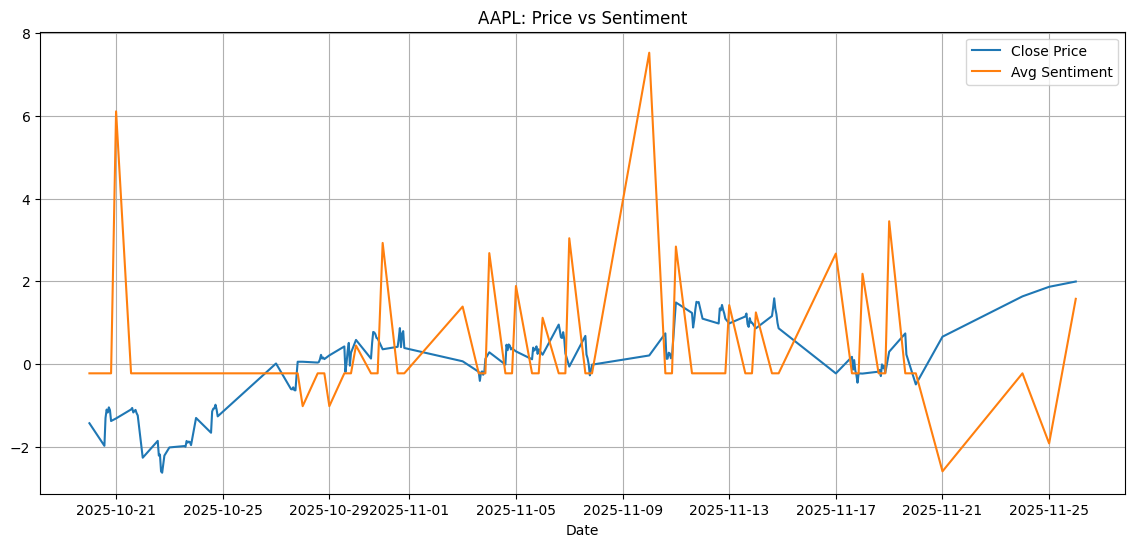

In [16]:
plt.figure(figsize=(14,6))
plt.plot(merged_prices_sent['date'], merged_prices_sent['price_z'], label='Close Price')
plt.plot(merged_prices_sent['date'], merged_prices_sent['sent_z'], label='Avg Sentiment')

plt.title(f"{ticker}: Price vs Sentiment")
plt.xlabel("Date")
plt.legend()
plt.grid()
plt.show()